In [ ]:
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab Notebooks/brain tumor/archive (2)/brain_tumor_dataset.zip

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `unzip /content/drive/MyDrive/Colab Notebooks/brain tumor/archive (2)/brain_tumor_dataset.zip'


In [ ]:

encoder = OneHotEncoder()
encoder.fit([[0], [1]])

# 0 - Tumor
# 1 - Normal

OneHotEncoder()

In [ ]:
import imutils
import cv2
from matplotlib import pyplot as plt

In [ ]:
def crop_brain_contour(image):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    return new_image

In [ ]:
# This cell updates result list for images with tumor

data = []
paths = []
result = []

for r, d, f in os.walk(r'/content/drive/MyDrive/BrainTumor2/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = cv2.imread(path)
    #img = Image.open(path)
    img =crop_brain_contour(img)
    #img = img.resize((128,128))
    img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)

    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [ ]:
# This cell updates result list for images without tumor

paths = []
for r, d, f in os.walk(r"/content/drive/MyDrive/BrainTumor2/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = cv2.imread(path)
    #img = Image.open(path)
    img =crop_brain_contour(img)
    #img = img.resize((128,128))
    img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)

    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [ ]:
data = np.array(data)
data.shape

(1311, 128, 128, 3)

In [ ]:
result = np.array(result)
result=result.reshape(1311,2)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      416       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
y_train.shape

(1048, 2)

In [ ]:
history = model.fit(x_train,y_train ,validation_data = (x_test, y_test), epochs=10)

Epoch 1/10
33/33 [==============================] - 65s 2s/step - loss: 3.0013 - val_loss: 2.5047
Epoch 2/10
33/33 [==============================] - 60s 2s/step - loss: 0.3936 - val_loss: 0.6688
Epoch 3/10
33/33 [==============================] - 58s 2s/step - loss: 0.2710 - val_loss: 0.4435
Epoch 4/10
33/33 [==============================] - 59s 2s/step - loss: 0.2007 - val_loss: 0.3155
Epoch 5/10
33/33 [==============================] - 58s 2s/step - loss: 0.1810 - val_loss: 0.2729
Epoch 6/10
33/33 [==============================] - 60s 2s/step - loss: 0.1274 - val_loss: 0.2841
Epoch 7/10
33/33 [==============================] - 57s 2s/step - loss: 0.1187 - val_loss: 0.2505
Epoch 8/10
33/33 [==============================] - 57s 2s/step - loss: 0.1163 - val_loss: 0.2045
Epoch 9/10
33/33 [==============================] - 59s 2s/step - loss: 0.1067 - val_loss: 0.2017
Epoch 10/10
33/33 [==============================] - 58s 2s/step - loss: 0.1072 - val_loss: 0.1860


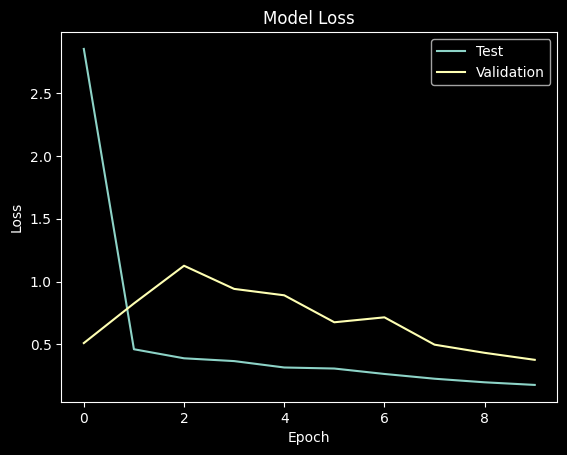

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')'.
'
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [ ]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

99.83262419700623% AccuracyNo, Its not a tumor


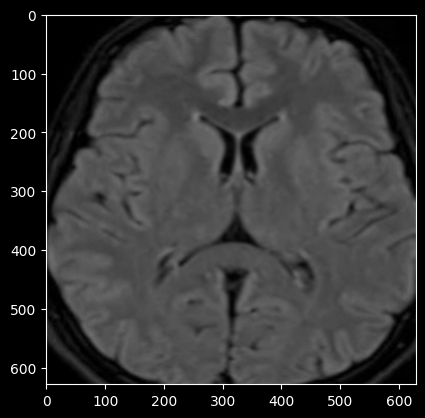

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/BrainTumor2/no/Te-noTr_0002.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Accuracy' + names(classification))

99.88760352134705% Accuracy No, Its not a tumor


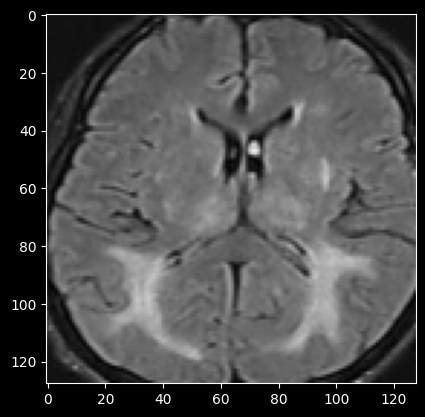

In [ ]:
from matplotlib.pyplot import imshow
img = cv2.imread("/content/drive/MyDrive/BrainTumor2/no/Te-noTr_0001.jpg")
    #img = Image.open(path)
img =crop_brain_contour(img)
#img = img.resize((128,128))
img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
x=np.array(img)
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Accuracy ' + names(classification))